# Project 2 - Ames Housing Price Prediction and Kaggle Challenge

## Problem Statement and Introduction

The housing market, a cornerstone of both individual lives and the broader economy, presents a complex landscape where accurate price predictions are of paramount importance. The Kaggle "Ames Housing Data" project offers an exciting opportunity to address this challenge comprehensively.

Determining the optimal selling price of a house is a multifaceted task, influenced by a multitude of variables. By harnessing the power of extensive data, our aim is to construct a robust linear regression model that excels in identifying the pivotal factors driving home valuations and producing precise predictions regarding housing prices in Ames, Iowa.

Specifically, our problem revolves around the question: **How can we effectively employ a linear regression model to enhance the accuracy of house sale price predictions?** The knowledge gained from this endeavor can prove invaluable for property owners seeking to maximize their home's market value and achieve a competitive edge in the real estate market.

The dataset contains a total of 2930 housing observations, and a large number of explanatory variables (23 nominal, 23 ordinal, 14 discrete, and 20 continuous) that includes critical attributes like square footage, Home functionality rating, kitchen quality and more. Within this dataset, these variables range from the objective and quantitative, such as the year built or the number of fireplaces, to the somewhat more subjective and qualitative, including evaluations of heating quality and exterior quality.

Our approach encompasses a holistic strategy that integrates feature engineering, feature selection, and regularization techniques. In this project, we have set two primary objectives: **to create a high-performing model and to ensure its reliability when dealing with new data**. We strive to consistently produce accurate predictions when confronted with previously unseen datasets, minimizing variations in predictive accuracy. Ultimately, we will assess the model's performance using the root mean squared error (RMSE) as a metric to measure the dissimilarity between the model's predictions and the actual observed values.

In [3]:
# Import libiries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sklearn.linear_model as linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

## Import the Datasets

In [4]:
# Load the dataset
train_data = pd.read_csv("datasets/train.csv")
test_data = pd.read_csv("datasets/test.csv")

## Columns and data types

In [5]:
train_data.head()

Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street Alley  \
0  109  533352170           60        RL           NaN     13517   Pave   NaN   
1  544  531379050           60        RL          43.0     11492   Pave   NaN   
2  153  535304180           20        RL          68.0      7922   Pave   NaN   
3  318  916386060           60        RL          73.0      9802   Pave   NaN   
4  255  906425045           50        RL          82.0     14235   Pave   NaN   

  Lot Shape Land Contour  ... Screen Porch Pool Area Pool QC Fence  \
0       IR1          Lvl  ...            0         0     NaN   NaN   
1       IR1          Lvl  ...            0         0     NaN   NaN   
2       Reg          Lvl  ...            0         0     NaN   NaN   
3       Reg          Lvl  ...            0         0     NaN   NaN   
4       IR1          Lvl  ...            0         0     NaN   NaN   

  Misc Feature Misc Val Mo Sold Yr Sold  Sale Type  SalePrice  
0          NaN        0       3    2010        WD      130500  
1          NaN        0       4    2009        WD      220000  
2          NaN        0       1    2010        WD      109000  
3          NaN        0       4    2010        WD      174000  
4          NaN        0       3    2010        WD      138500  

[5 rows x 81 columns]

In [6]:
# Explore the dataset
# Summary of columns and data types
print(train_data.info())  

# Summary statistics
print(train_data.describe())  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     1721 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Alley            140 non-null    object 
 8   Lot Shape        2051 non-null   object 
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   object 
 11  Lot Config       2051 non-null   object 
 12  Land Slope       2051 non-null   object 
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

In [7]:
# Separate features into numeric and categorical
numeric_features = train_data.select_dtypes(include=['number']).columns.tolist()
categorical_features = train_data.select_dtypes(include=['object']).columns.tolist()

## Visualize the target variable 

Our main target variable is Sale Prince. 

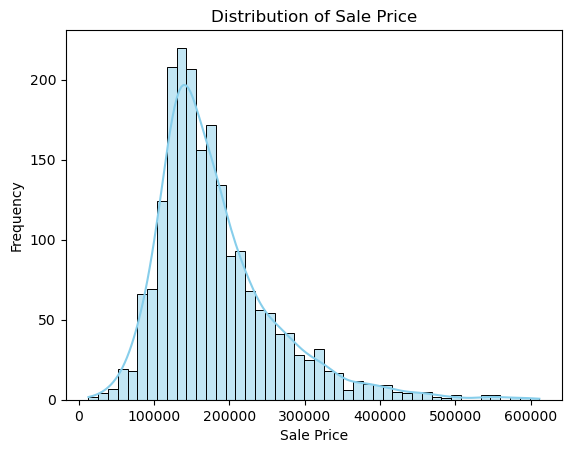

In [10]:
# Visualize the distribution of the target variable (SalePrice)
sns.histplot(train_data['SalePrice'], color='skyblue', kde=True)
plt.title("Distribution of Sale Price")
plt.xlabel("Sale Price")
plt.ylabel("Frequency")


plt.savefig('sale_price_distribution.png')
plt.show()

The distribution of Sale price is not normal. It is **right-skewed**, positively skewed distribution. The majority of data points for Sale price are on the left, causing the mean sales prices to be greater than the median.

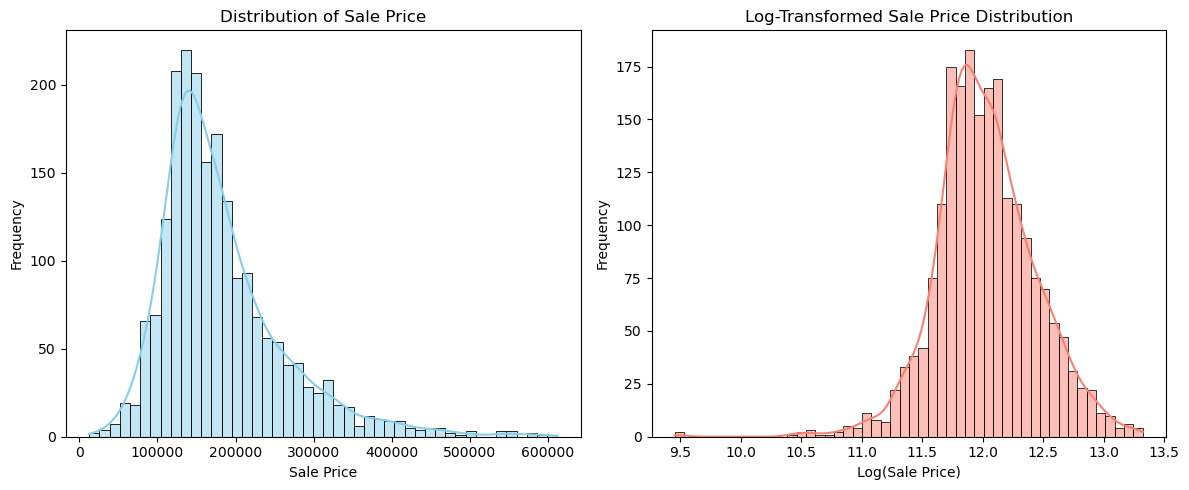

In [11]:
# Create a figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histogram
sns.histplot(train_data['SalePrice'], kde=True, ax=ax1, color='skyblue')
ax1.set_title("Distribution of Sale Price")
ax1.set_xlabel("Sale Price")
ax1.set_ylabel("Frequency")

# Plot a log-transformed histogram for a clearer view
log_sale_price = np.log1p(train_data['SalePrice'])
sns.histplot(log_sale_price, kde=True, ax=ax2, color='salmon')
ax2.set_title("Log-Transformed Sale Price Distribution")
ax2.set_xlabel("Log(Sale Price)")
ax2.set_ylabel("Frequency")


plt.tight_layout()
plt.savefig('Log_sale_price_distribution.png')
plt.show()

The **Log-Transformed Sale Price Distribution** exhibits a more normal distribution. This suggests that employing this transformation can be a beneficial preprocessing step when working with this data.

# Linear relationship between Outcome variable and Independent Variables

In [12]:
def train_scatterplot(dataframe, list_of_columns, target, save_path=None):
    sns.set(style="white")
    
    num_plots = len(list_of_columns)
    ncols = 4
    nrows = (num_plots - 1) // ncols + 1 
    
    # Create subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, nrows * 3))
    axes = axes.ravel()
    
    for i, column in enumerate(list_of_columns):
        if i < num_plots:
            
            # Scatter plot with a regression line
            sns.scatterplot(data=dataframe, x=column, y=target, ax=axes[i], color='skyblue', alpha=0.6, label ="Data Point")
            sns.regplot(data=dataframe, x=column, y=target, ax=axes[i], scatter=False, color='blue', label="Regression Line", line_kws={'color': 'blue'})
            axes[i].set_title(f"{column} vs {target}", fontsize=14)
            axes[i].set_xlabel(column)
            axes[i].set_ylabel(target)
            axes[i].legend(fontsize=6)
    
    # Removing empty subplots
    for i in range(num_plots, nrows * ncols):
        fig.delaxes(axes[i])
    
    plt.suptitle(f'Scatterplots of Numeric Features vs {target}', fontsize=20, y=1.02)
    plt.tight_layout()
    
    # Save the plot
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

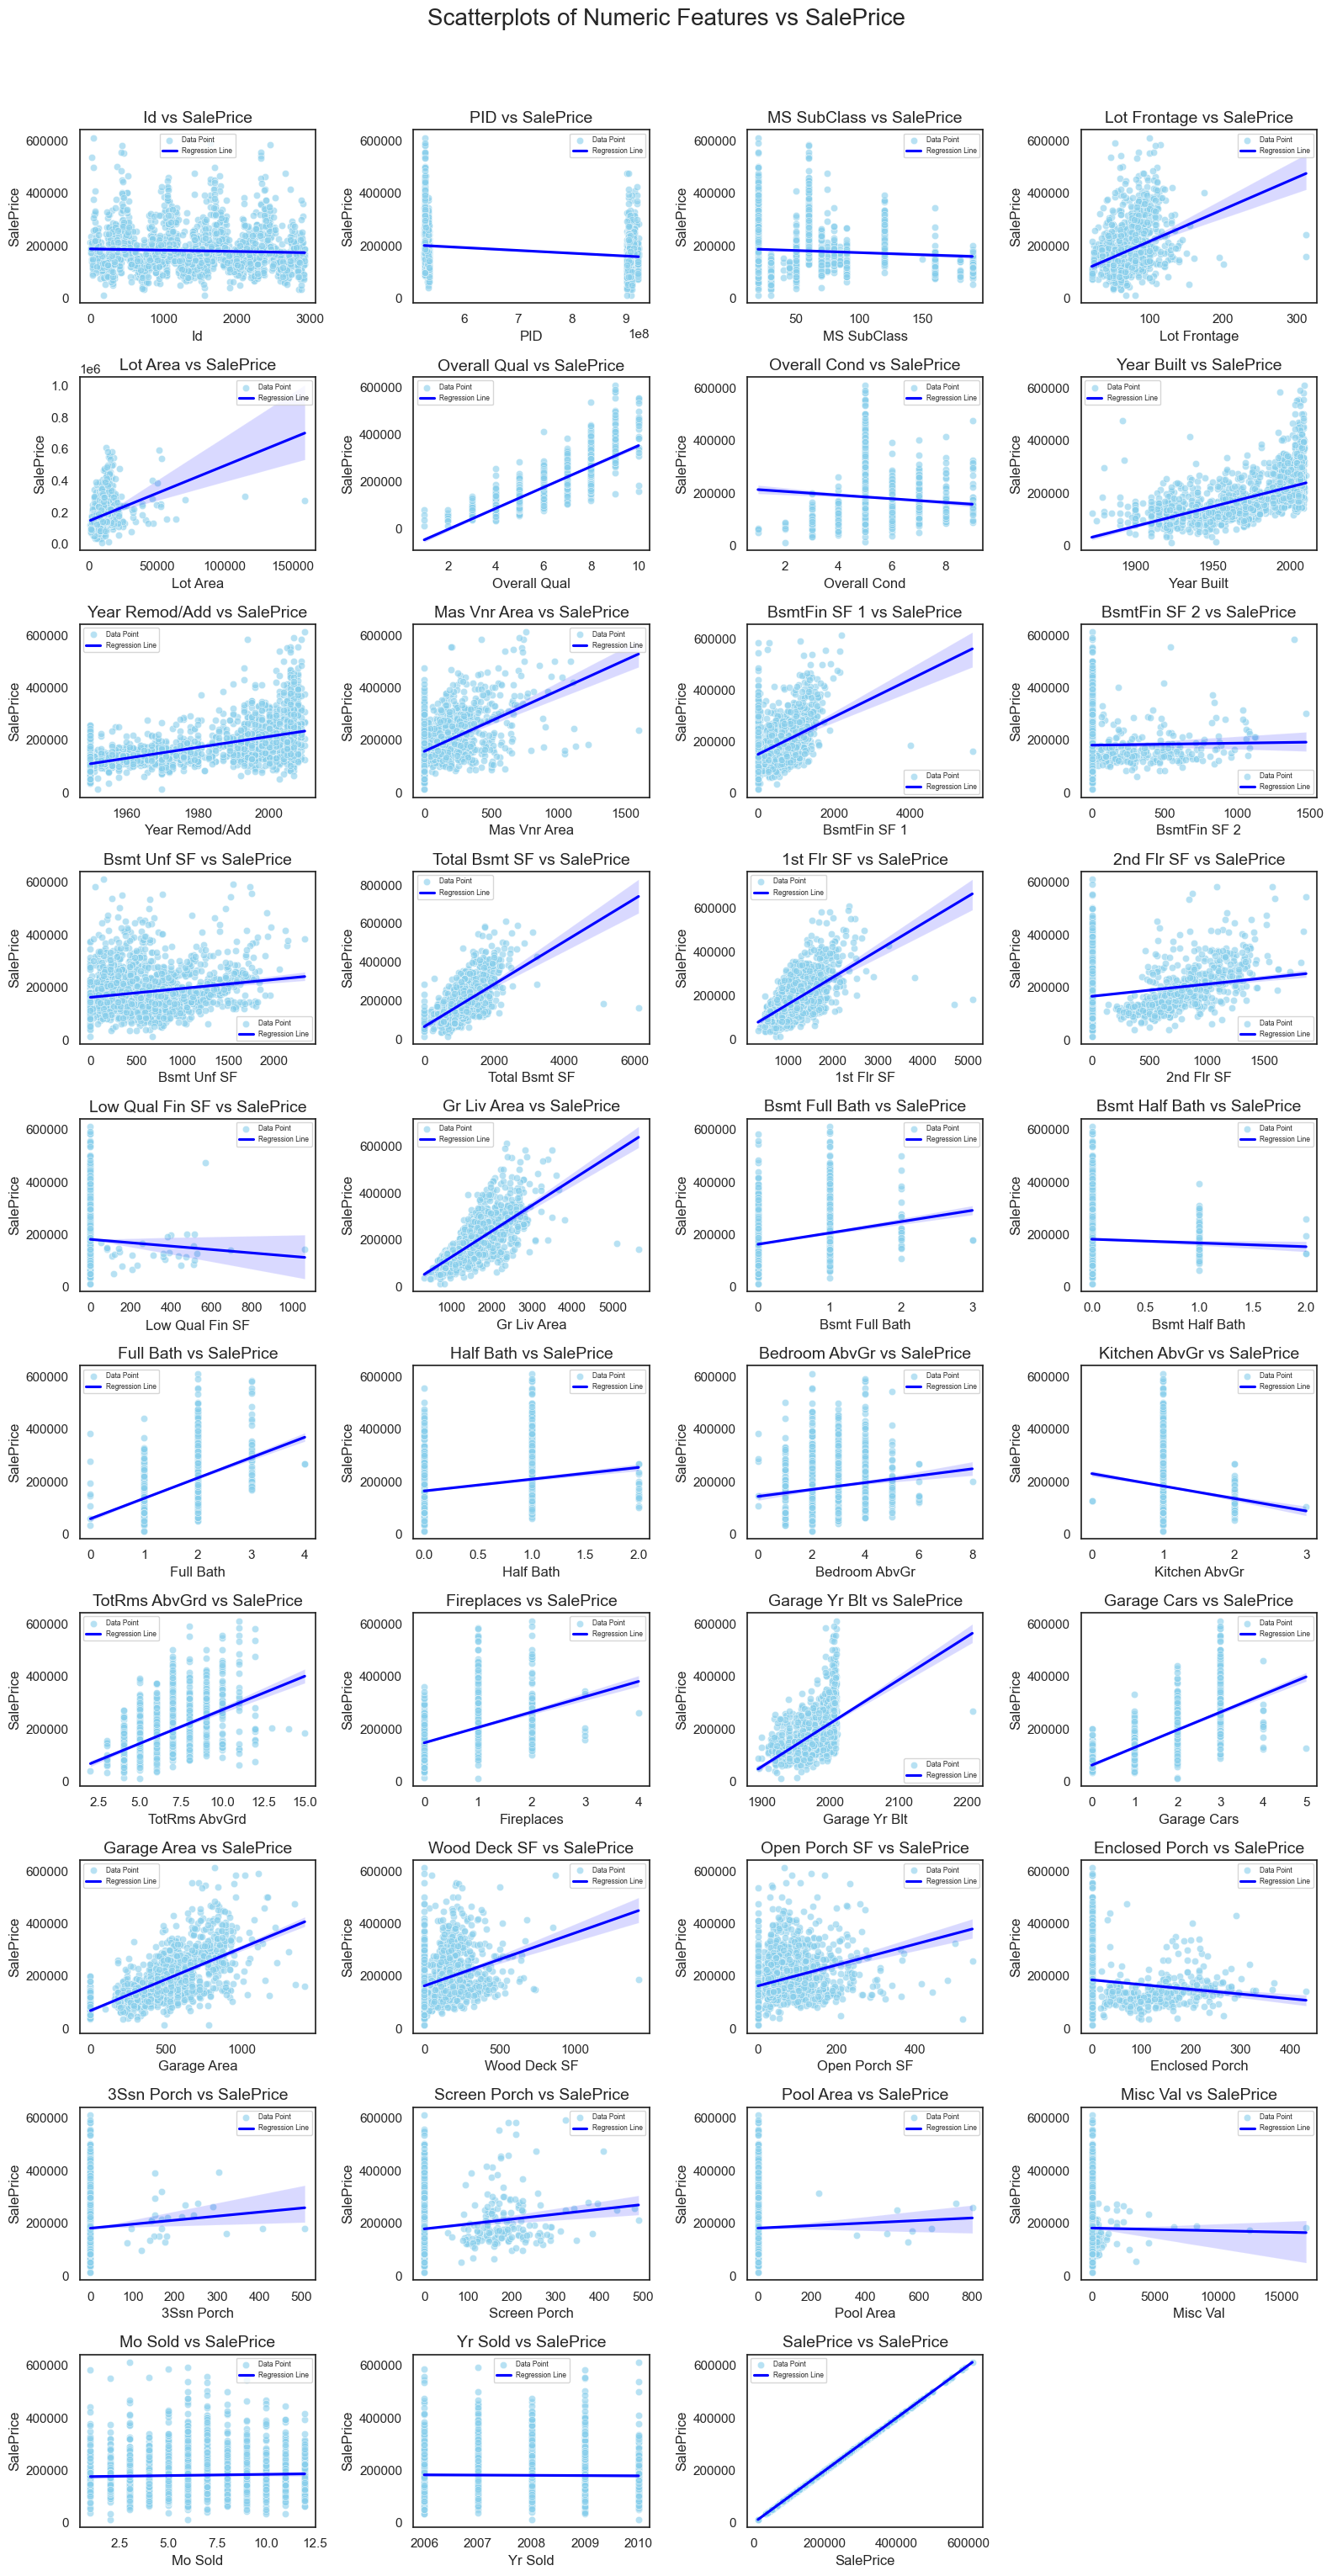

In [13]:
#show scatterplot
train_scatterplot(train_data, numeric_features, 'SalePrice', save_path='train_scatterplot.png')

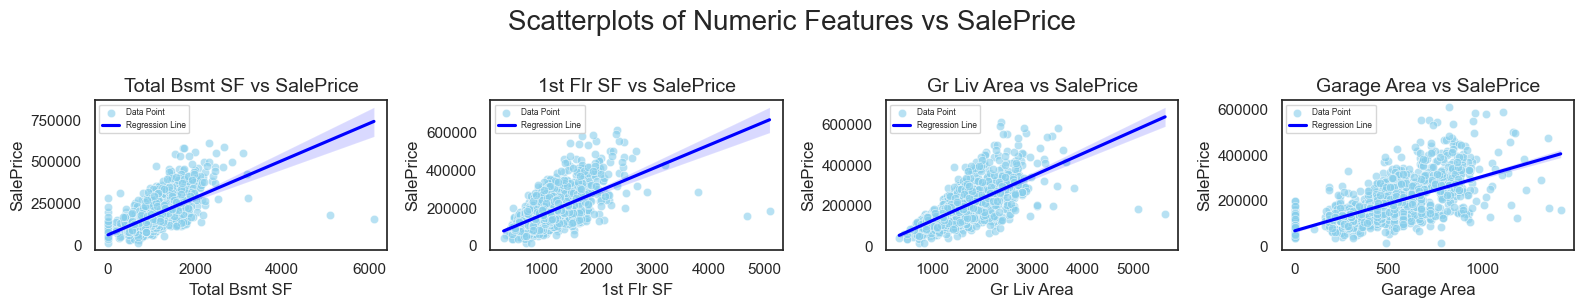

In [14]:
train_scatterplot(train_data, ['Total Bsmt SF', '1st Flr SF', 'Gr Liv Area', 'Garage Area'], 'SalePrice', save_path='potential_Scattered Plot')

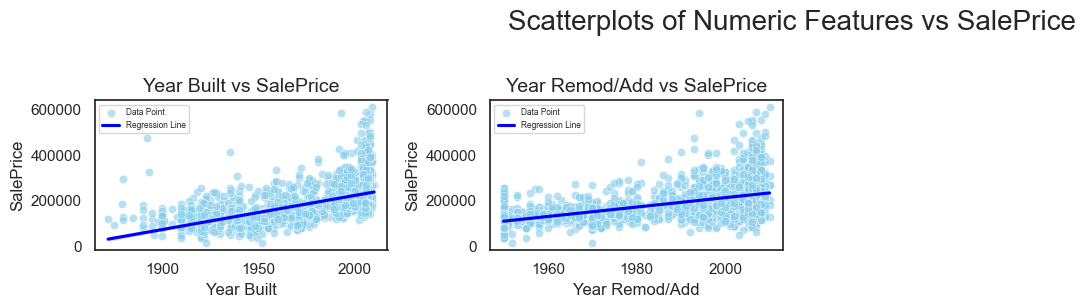

In [15]:
train_scatterplot(train_data, ['Year Built', 'Year Remod/Add'], 'SalePrice', save_path='Year_Scattered Plot')

In [18]:
def eda_scatterplot(dataframe, list_of_columns, target, save_path=None):
    sns.set(style="white")
    
    num_plots = len(list_of_columns)
    ncols = 2 
    nrows = (num_plots - 1) // ncols + 1
    
    # Creating a color palette for plots
    colors = sns.color_palette("husl", num_plots)
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, nrows * 3))
    axes = axes.ravel()
    
    for i, column in enumerate(list_of_columns):
        if i < num_plots: 
            
            # Scatter plot with a regression line
            sns.scatterplot(data=dataframe, x=column, y=target, ax=axes[i], color=colors[i], alpha=0.6, label="Data Points")
            sns.regplot(data=dataframe, x=column, y=target, ax=axes[i], scatter=False, color=colors[i], label="Regression Line", line_kws={'color': colors[i]})
            axes[i].set_title(f"{column} vs {target}", fontsize=14)
            axes[i].set_xlabel(column)
            axes[i].set_ylabel(target)
            axes[i].legend(fontsize=6)
    
    for i in range(num_plots, nrows * ncols):
        fig.delaxes(axes[i])
    
    plt.suptitle(f'Scatterplots of Numeric Features vs {target}', fontsize=20, y=1.02)
    plt.tight_layout()

    # Save the plot
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

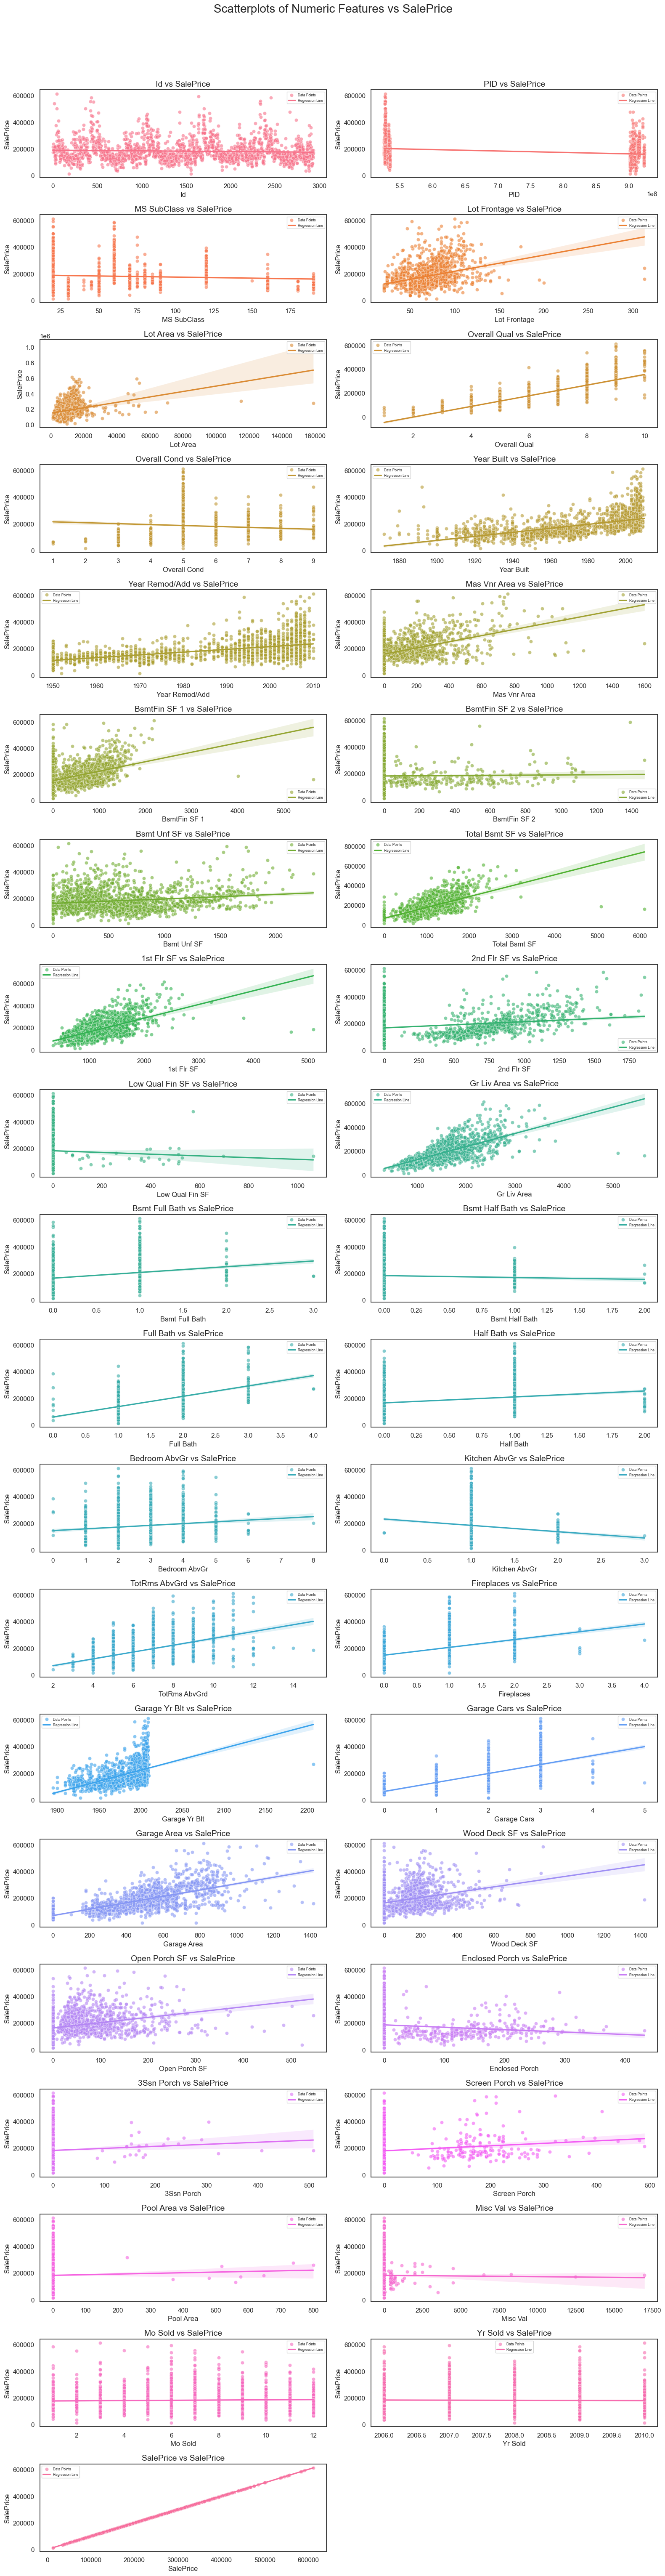

In [19]:
#Show and save the scatterplot
eda_scatterplot(train_data, numeric_features, 'SalePrice', save_path='eda_scatterplot.png')

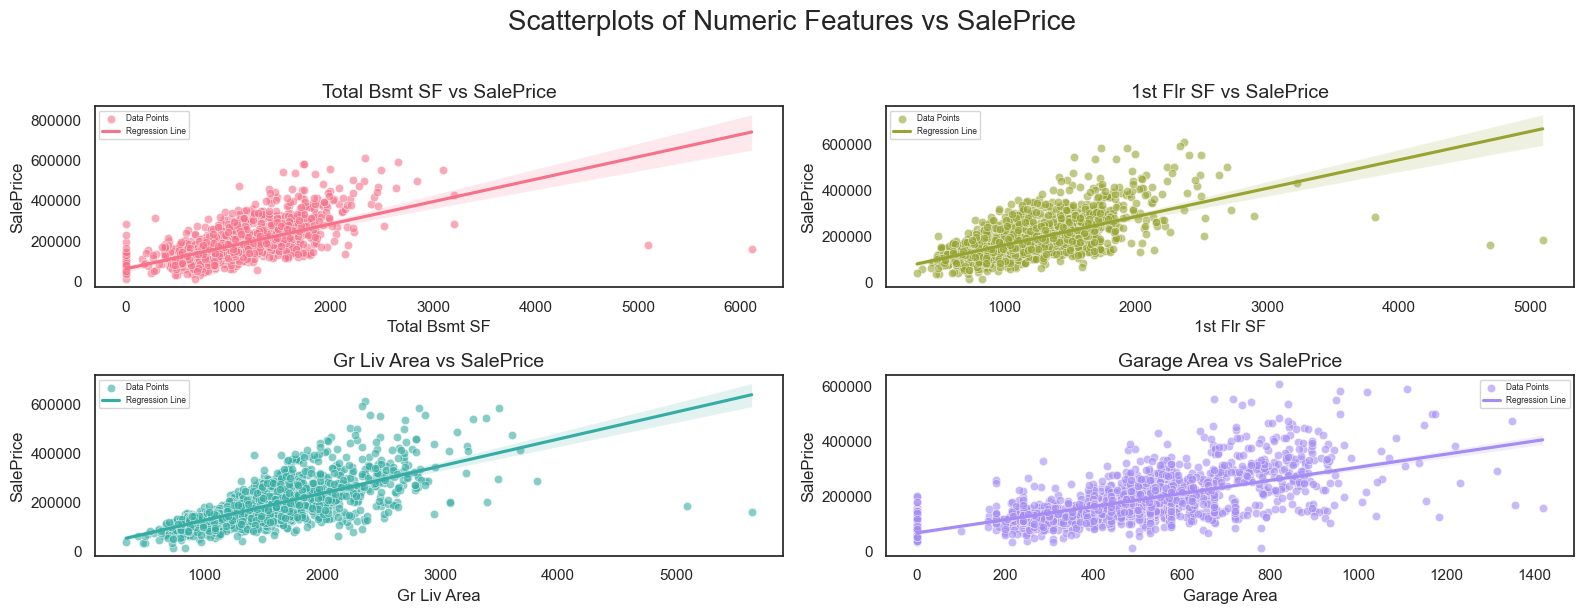

In [20]:
eda_scatterplot(train_data, ['Total Bsmt SF', '1st Flr SF', 'Gr Liv Area', 'Garage Area'], 'SalePrice', save_path='eda_potential_Scattered Plot')

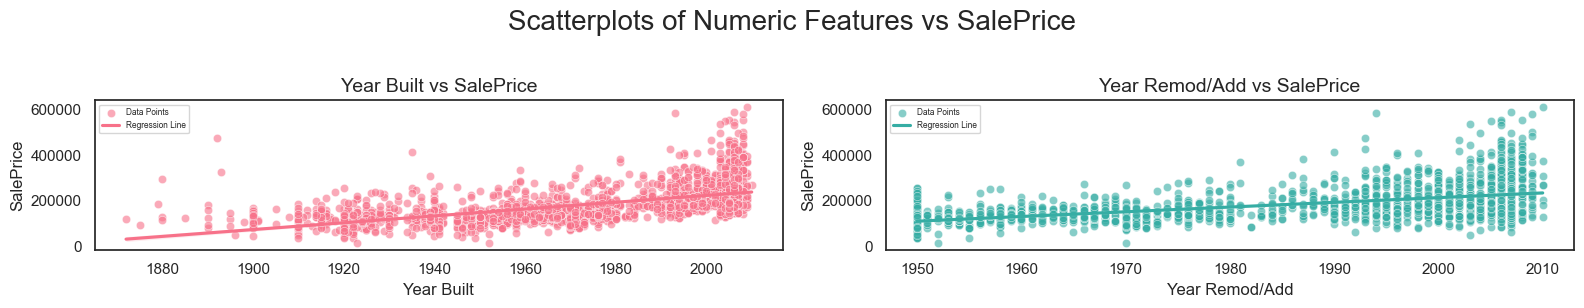

In [21]:
eda_scatterplot(train_data, ['Year Built', 'Year Remod/Add'], 'SalePrice', save_path='eda_Year_Scattered Plot')

There exists a strong positive linear relationship, particularly noticeable in variables such as Total square feet of basement area, First Floor square feet, Above grade (ground) living area square feet, Size of garage in square feet, Year Build, and Year Remodel/Add, which consistently show positive correlations with SalePrice.

# Data Distribution

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_numeric_histograms(dataframe, numeric_columns, save_path=None):
    num_features = len(numeric_columns)
    ncols = 3  # Number of columns per row
    nrows = (num_features - 1) // ncols + 1  # Calculate the number of rows
    
    # Create a custom color palette
    custom_palette = sns.color_palette("Set2", n_colors=num_features)
    
    # Create subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
    fig.subplots_adjust(hspace=0.5)  # Adjust vertical spacing
    
    # Flatten the axes for iteration
    axes = axes.flatten()
    
    for i, column in enumerate(numeric_columns):
        ax = axes[i]
        
        # Create a histogram with a customized color
        sns.histplot(data=dataframe, x=column, kde=True, ax=ax, color=custom_palette[i], bins=30, stat="density")
        
        # Annotate the mean and median on the plot
        mean_value = dataframe[column].mean()
        median_value = dataframe[column].median()
        ax.axvline(mean_value, color='r', linestyle='--', label=f'Mean: {mean_value:.2f}')
        ax.axvline(median_value, color='g', linestyle='--', label=f'Median: {median_value:.2f}')
        
        ax.set_title(f'Distribution of {column}', fontsize=14)
        ax.set_xlabel('')
        ax.set_ylabel('Density')
        ax.tick_params(labelsize=10)
        
        # legend for mean and median annotations
        ax.legend()
    
    # Hide any unused subplots
    for j in range(i + 1, nrows * ncols):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    
    # Save the plot
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
    plt.show()

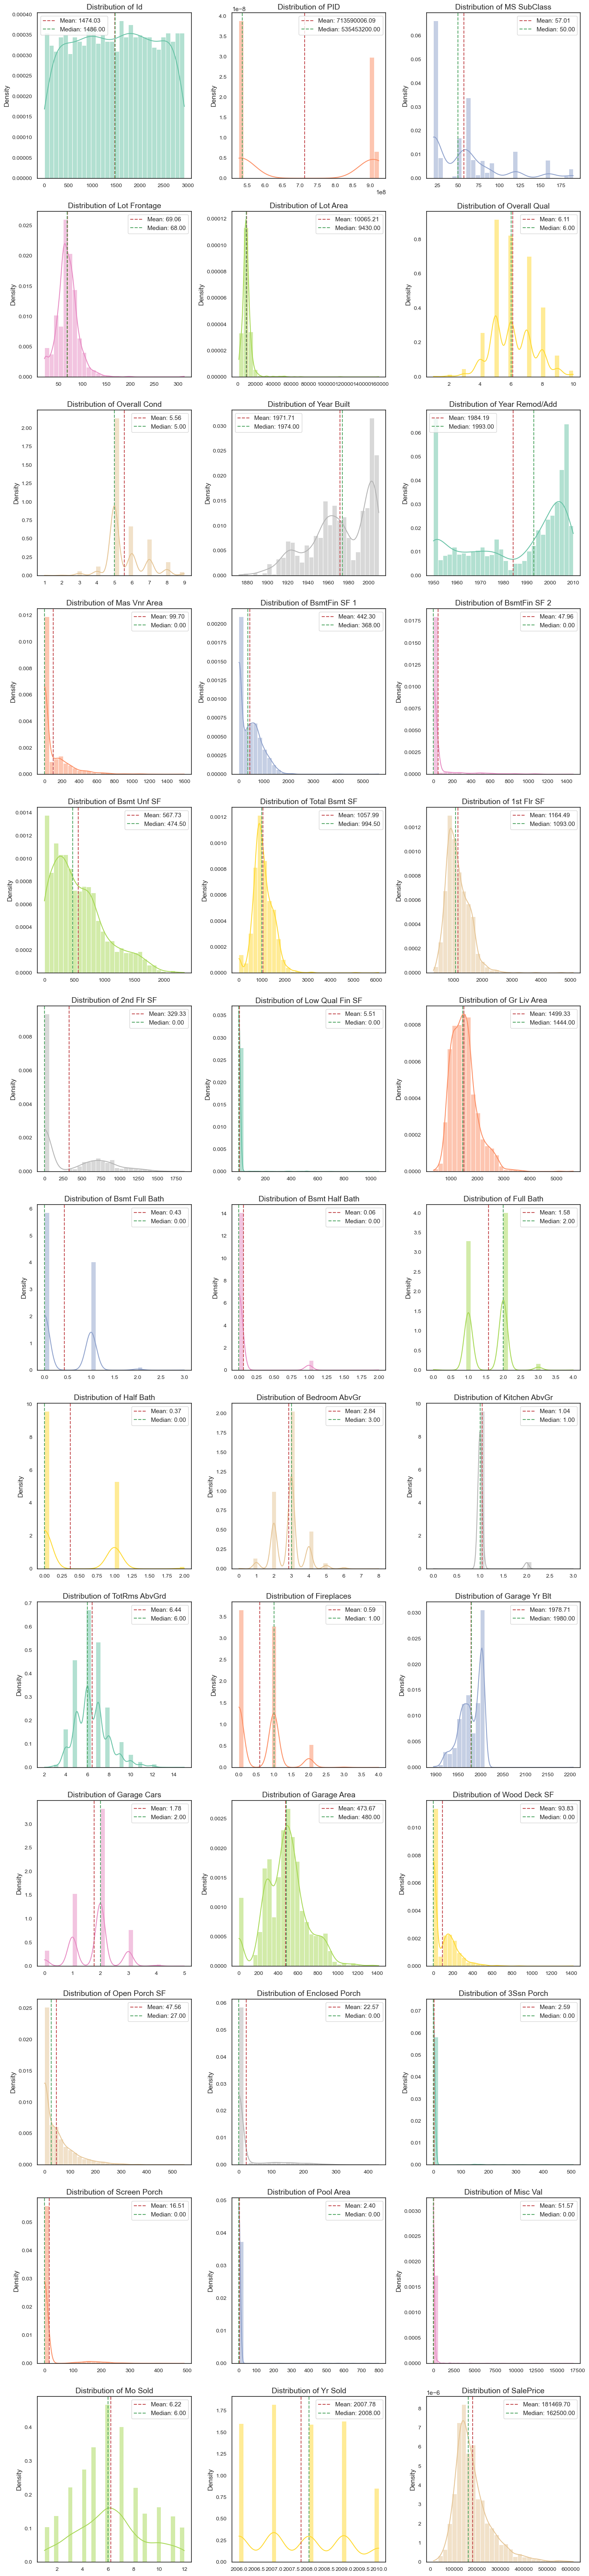

In [23]:
plot_numeric_histograms(train_data, numeric_features, save_path='train_histograms')

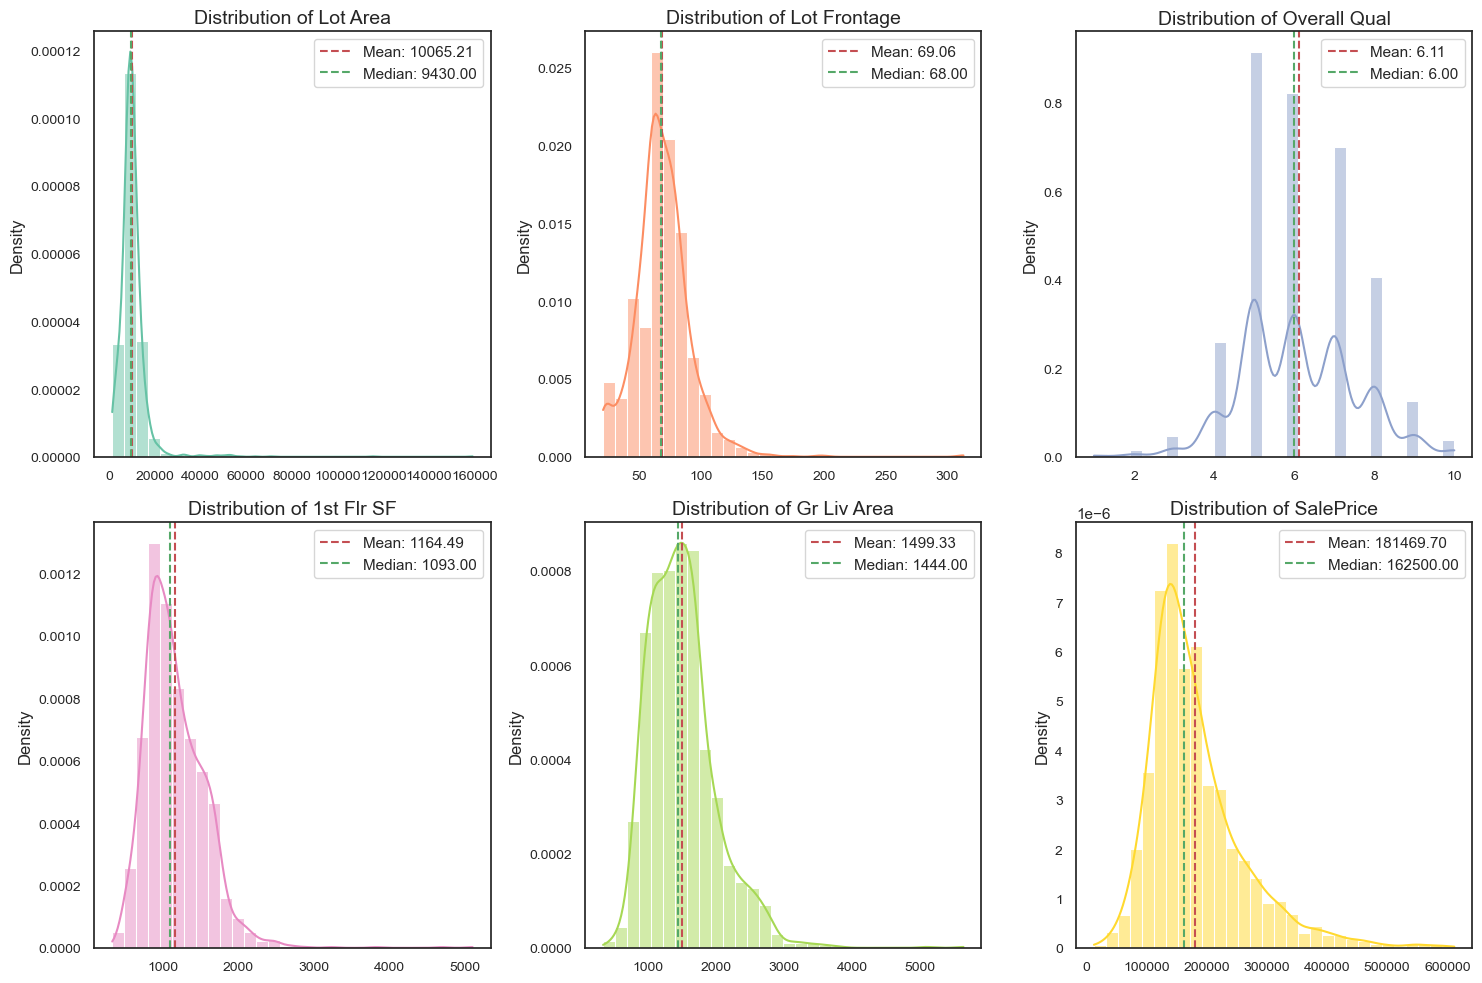

In [25]:
plot_numeric_histograms(train_data,['Lot Area', 'Lot Frontage','Overall Qual', '1st Flr SF', 'Gr Liv Area', 'SalePrice'], save_path='train_potential_histogram')

### Histogram Multivarible Normality Results

Based in these distribution, there are very few normal distribution. But there are many close to normal distribition which are **Overall Qual, Overall, Cond, 1st Floor SF, Total Bsmnt, Gr Liv Area, Garage Area, and Sale Price.**

To get a better normal distribution, I tried to log-tranfrom the columns. 

In [241]:
# Apply the log transformation to the columns
numeric_columns = train_data.select_dtypes(include=[np.number]).columns
train_data[numeric_columns] = np.log1p(train_data[numeric_columns])

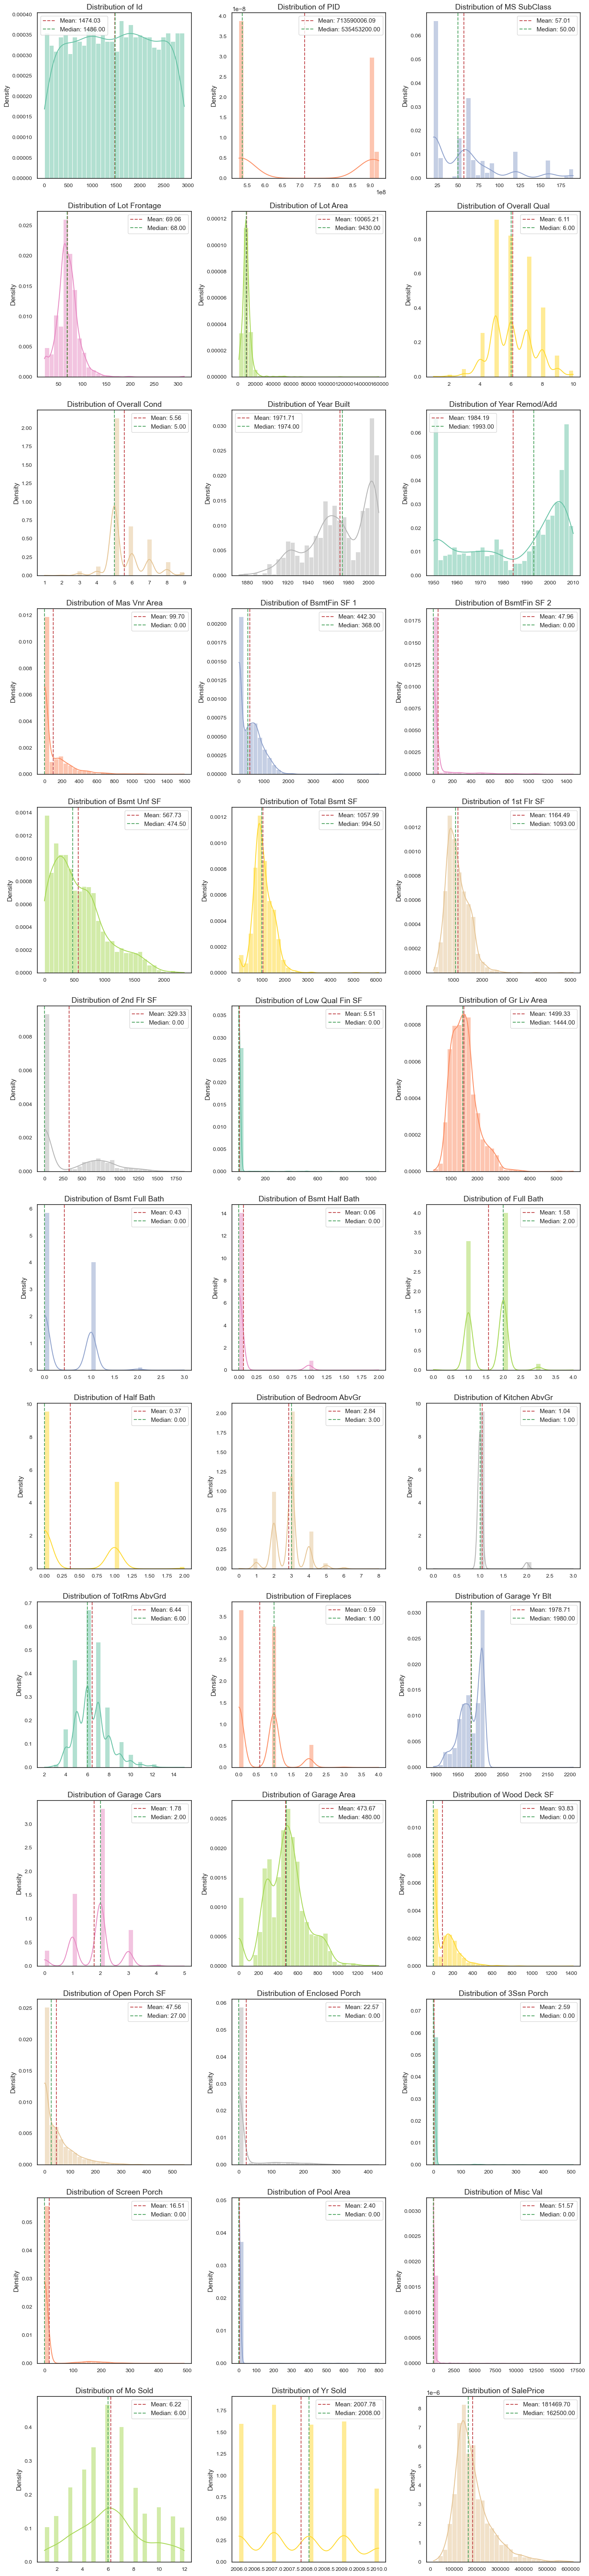

In [244]:
# Plot the histograms of the log-transformed data
plot_numeric_histograms(train, numeric_columns, save_path ="log_train_histogram")

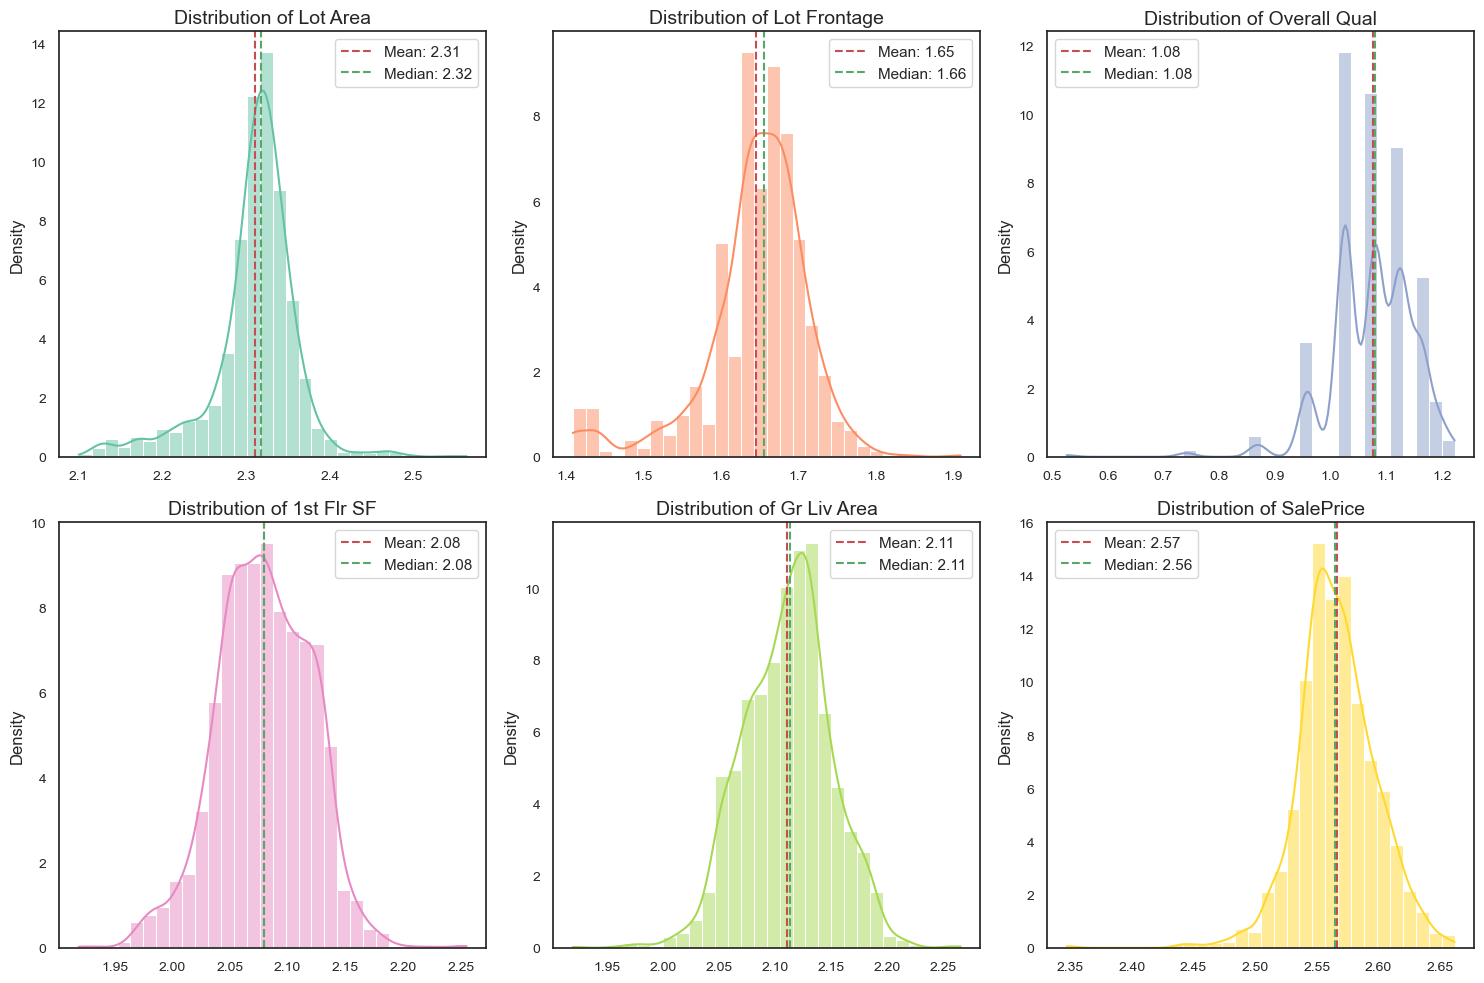

In [252]:
plot_numeric_histograms(train_data,['Lot Area', 'Lot Frontage','Overall Qual', '1st Flr SF', 'Gr Liv Area', 'SalePrice'], save_path='log_train_potential_histogram')

### Log-transformation Results

Log transformation of 'Lot Area', 'Lot Frontage','Overall Qual', '1st Flr SF', 'Gr Liv Area', and 'SalePrice' have close to normal distribution. '1st Flr SF' and 'Gr Liv Area' also have good linear relationship with 'Sales Price'.

In [290]:
# Load the dataset
train_data = pd.read_csv("datasets/train.csv")
test_data = pd.read_csv("datasets/test.csv")

In [27]:
def plot_categorical_stripplots(dataframe, categorical_columns, target_column):
    num_columns = len(categorical_columns)
    num_columns_per_row = 4
    num_rows = (num_columns - 1) // num_columns_per_row + 1
    
    # Create a custom color palette for better distinction
    custom_palette = sns.color_palette("Set2", n_colors=num_columns)
    
    # Temporarily suppress warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        plt.figure(figsize=(20, 5 * num_rows))
    
        for i, column in enumerate(categorical_columns):
            plt.subplot(num_rows, num_columns_per_row, i + 1)
            sns.stripplot(data=dataframe, x=target_column, y=column, orient='h', palette=[custom_palette[i]])
            plt.title(column, fontsize=16)
            plt.xlabel(target_column, fontsize=14)
            plt.ylabel(column, fontsize=14)
            plt.xticks(rotation=45)
    
        plt.suptitle('Categorical Features vs Sale Price', fontsize=20, y=1.02)
        plt.tight_layout()
        plt.show()

In [29]:
plot_categorical_stripplots(train_data, categorical_features, 'SalePrice')

TypeError: plot_categorical_stripplots() got an unexpected keyword argument 'save_path'

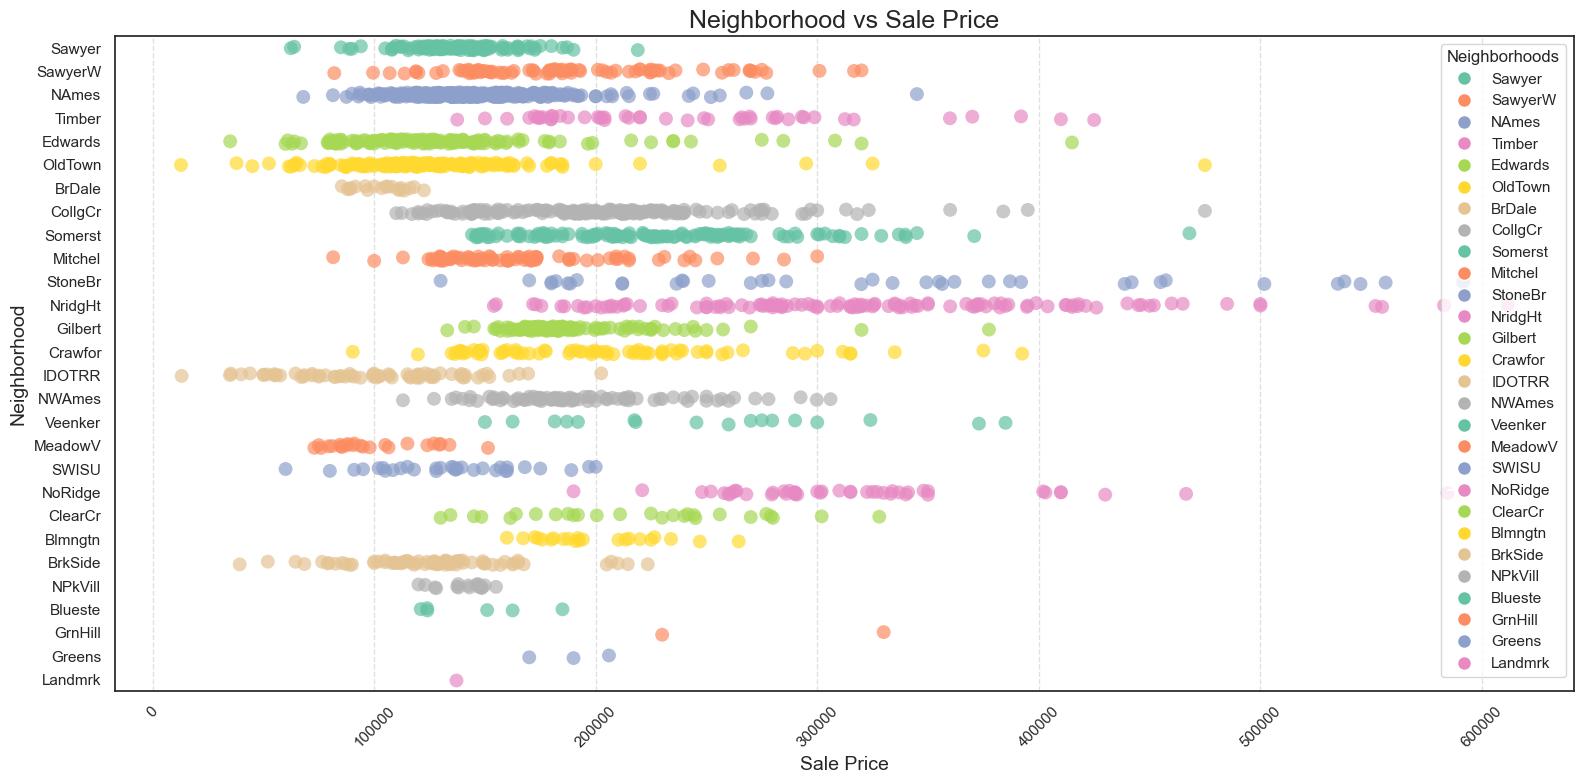

In [293]:
custom_palette = sns.color_palette("Set2", n_colors=len(train_data['Neighborhood'].unique()))

# Temporarily suppress warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    plt.figure(figsize=(16, 8))
    
    # Create a horizontal strip plot
    sns.stripplot(
        data=train_data, 
        x='SalePrice', 
        y='Neighborhood', 
        palette=custom_palette, 
        jitter=True,
        size=10,  
        alpha=0.7,
        marker='o',
        edgecolor='k',
    )
    
    # axis labels and title
    plt.xticks(rotation=45)
    plt.title('Neighborhood vs Sale Price', fontsize=18)
    plt.ylabel('Neighborhood', fontsize=14)
    plt.xlabel('Sale Price', fontsize=14)
    
    #legend for neighborhood categories
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in custom_palette]
    labels = train_data['Neighborhood'].unique()
    plt.legend(handles, labels, title='Neighborhoods', title_fontsize=12, loc='upper right')
    
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig("Neighborhood and SalesPrice.png", dpi=300, bbox_inches='tight')
    
plt.show()

# Multicollinearity

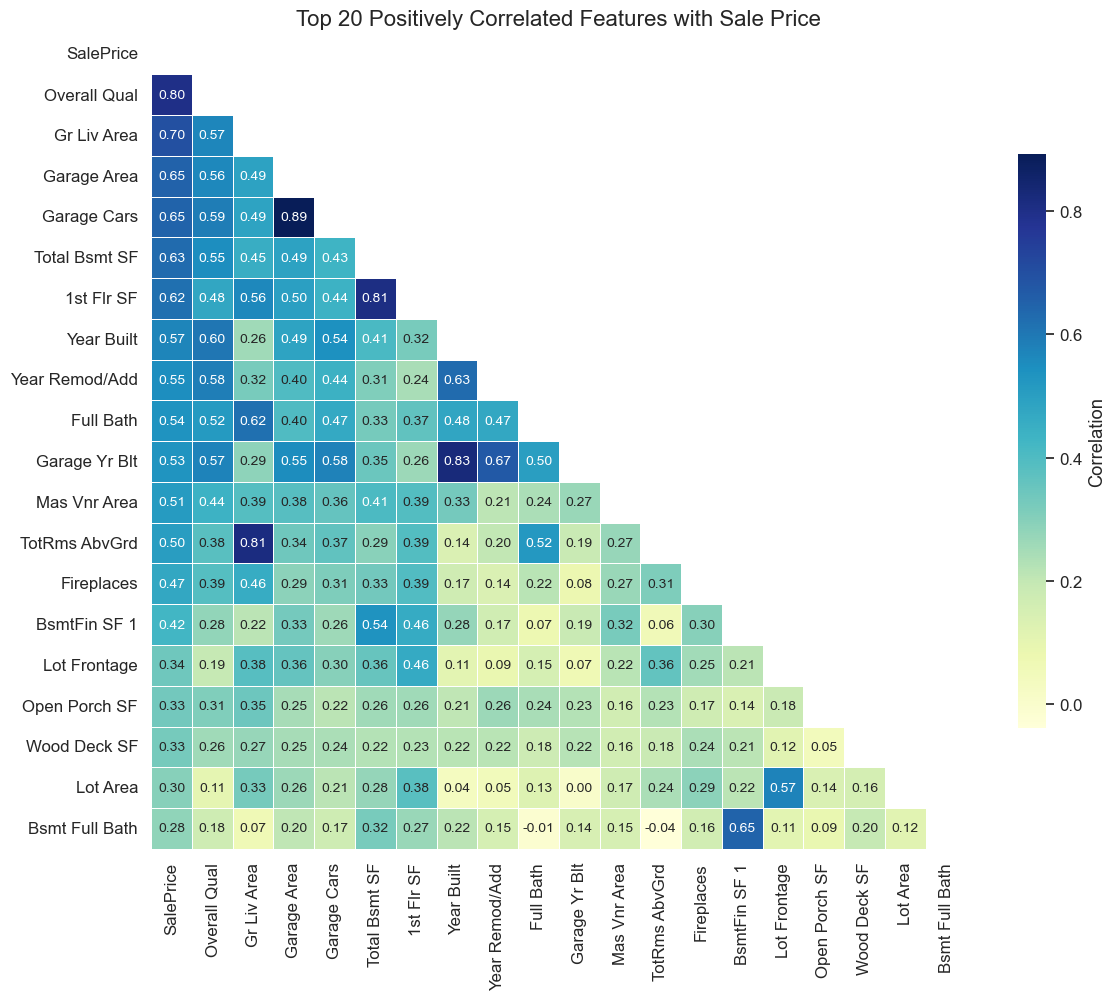

In [301]:
# Create a mask for the upper triangle of the correlation matrix
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the figure and axes with a white background
plt.figure(figsize=(12, 10))
sns.set(font_scale=1.1)  # Increase font size for readability
sns.set_style("white")  # Set the background style to white

# Define the colormap
cmap = "YlGnBu"

# Temporarily suppress warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # Customize the heatmap
    sns.heatmap(
        corr_matrix,
        cmap=cmap,
        mask=mask,
        square=True,
        annot=True,
        annot_kws={"fontsize": 10},  # Adjust annotation font size
        linewidths=0.5,  # Add linewidths to separate cells
        fmt=".2f",  # Format values with two decimal places
        cbar=True,  # Show colorbar
        cbar_kws={"label": "Correlation", "shrink": 0.7},  # Customize colorbar
    )

# Set title and adjust plot spacing
plt.title('Top 20 Positively Correlated Features with Sale Price', fontsize=16)
plt.tight_layout()

# Save the heatmap
plt.savefig("Multicollinearity.png", dpi=300, bbox_inches='tight', transparent=True)

# Show the improved heatmap
plt.show()

R2: 0.841080867182792
RMSE: 31588.493600183716
MAE: 20576.908667737138


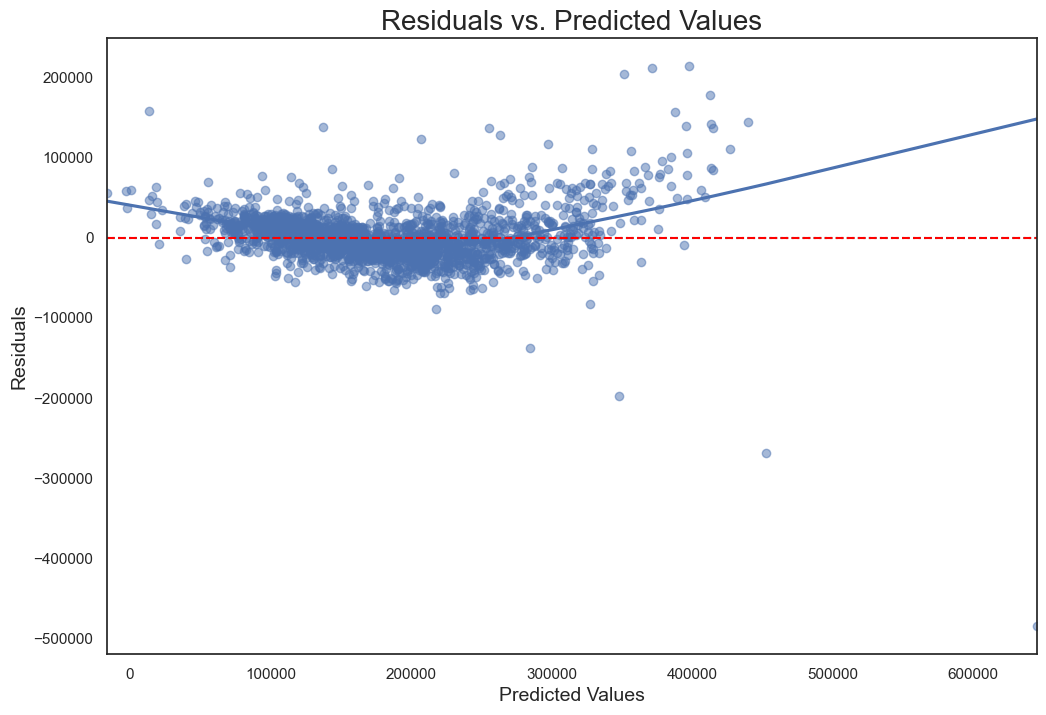

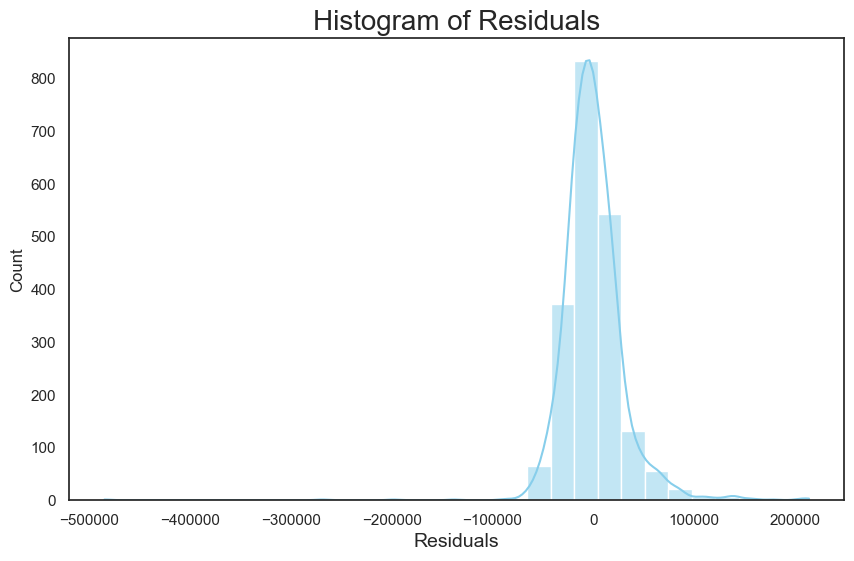

In [34]:
# Temporarily fill in null values to allow for plotting of residuals
train = train_data.fillna(0)

# Creation of the baseline linear model
features = [col for col in train._get_numeric_data().columns if col != 'SalePrice']
X = train[features]
y = train['SalePrice']

lr = LinearRegression()
lr.fit(X, y)
y_pred = lr.predict(X)

# Calculate additional statistics
r2 = lr.score(X, y)
rmse = np.sqrt(mean_squared_error(y, y_pred))
mae = mean_absolute_error(y, y_pred)

# Plotting residuals with a smoother line
plt.figure(figsize=(12, 8))
sns.residplot(x=y_pred, y=y - y_pred, lowess=True, scatter_kws={'alpha': 0.5})
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs. Predicted Values', fontsize=20)
plt.ylabel('Residuals', fontsize=14)
plt.xlabel('Predicted Values', fontsize=14)

plt.figure(figsize=(10, 6))
sns.histplot(y - y_pred, kde=True, bins=30, color='skyblue')
plt.title('Histogram of Residuals', fontsize=20)
plt.xlabel('Residuals', fontsize=14)

# Additional statistics
print('R2:', r2)
print('RMSE:', rmse)
print('MAE:', mae)

# Save
plt.savefig("Homoscedacity.png", dpi=300, bbox_inches='tight', transparent=True)

plt.show()

# EDA Summary